In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable(logging.CRITICAL)

In [ ]:
!pip install darts
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mae
from darts.metrics import mape
from darts.metrics import mse
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.explainability.tft_explainer import TFTExplainer

In [ ]:
df = pd.read_excel("EUNG.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df

,EUNG,EUNG_LAG1,EUNG_LAG2,EUNG_LAG3,EUNG_LAG4,USAGDP,Equity Market Volatility,3 Month Treasury Bill,Infectious Disease Tracker,COV19,RUWAR
DATE,,,,,,,,,,,
1996-07-01,0.000000,0.003724,-0.018485,-0.014546,0.029306,0.020675,-4.19,0.09,-0.196710,0,0
1996-10-01,0.088868,0.000000,0.003724,-0.018485,-0.014546,0.012196,1.94,0.08,0.083382,0,0
1997-01-01,-0.013699,0.088868,0.000000,0.003724,-0.018485,0.015662,-0.40,-0.12,-0.446287,0,0
1997-04-01,-0.060409,-0.013699,0.088868,0.000000,0.003724,0.012380,2.70,0.08,0.782759,0,0
1997-07-01,-0.048790,-0.060409,-0.013699,0.088868,0.000000,0.018502,-0.41,-0.01,0.041964,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.646442,-0.044776,0.021344,0.636412,0.631536,0.020373,-0.43,0.77,-0.083527,1,1
2022-10-01,-0.730063,0.646442,-0.044776,0.021344,0.636412,0.017477,-3.25,1.58,-0.269102,1,1
2023-01-01,-0.520405,-0.730063,0.646442,-0.044776,0.021344,0.015792,1.58,1.38,0.005921,1,1


In [ ]:
selected_columns = ["EUNG","EUNG_LAG1"]
pruned_df = df[selected_columns]

pruned_df = pruned_df.set_index(df.index)
pruned_df

,EUNG,EUNG_LAG1
DATE,,
1996-07-01,0.000000,0.003724
1996-10-01,0.088868,0.000000
1997-01-01,-0.013699,0.088868
1997-04-01,-0.060409,-0.013699
1997-07-01,-0.048790,-0.060409
...,...,...
2022-07-01,0.646442,-0.044776
2022-10-01,-0.730063,0.646442
2023-01-01,-0.520405,-0.730063


## Create Darts Series for Pandas DF

In [ ]:
# Convert the DataFrame to a TimeSeries object
series = TimeSeries.from_dataframe(pruned_df, value_cols='EUNG')
series = series.astype(np.float32)

### Splitting

In [ ]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20210701")
train, val = series.split_after(training_cutoff)

### Normalization

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### Create Covariates

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="quarter", one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index,values=np.arange(len(series)),columns=["linear_increase"],))
covariates = covariates.astype(np.float32)

In [ ]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

## Built the Self Attention Model

In [ ]:
len(train_transformed)

101

In [ ]:
num_samples = 101
input_chunk_length = 16
forecast_horizon = 8

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 16
forecast_horizon = 1#1 #12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=256,#256
    lstm_layers=2,#2
    num_attention_heads=14,#14
    dropout=0.2,#0.2
    batch_size=4,#4
    n_epochs=25,#25
    add_relative_index=False,
    add_encoders=None, #{'cyclic': {'future': ['month']}}#0.40
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=69,
)

## Fit the Model

In [ ]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=256, lstm_layers=2, num_attention_heads=14, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=16, output_chunk_length=1, batch_size=4, n_epochs=25, add_encoders=None, random_state=69)

## Define Presentation

In [ ]:
figsize = (14, 8)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## Prediction and Rescaling

In [ ]:
n=8
pred_series = my_model.predict(n=n, num_samples=num_samples)

forecast = transformer.inverse_transform(pred_series)
eval = transformer.inverse_transform(val_transformed)
st = transformer.inverse_transform(series_transformed)

Predicting: |          | 0/? [00:00<?, ?it/s]

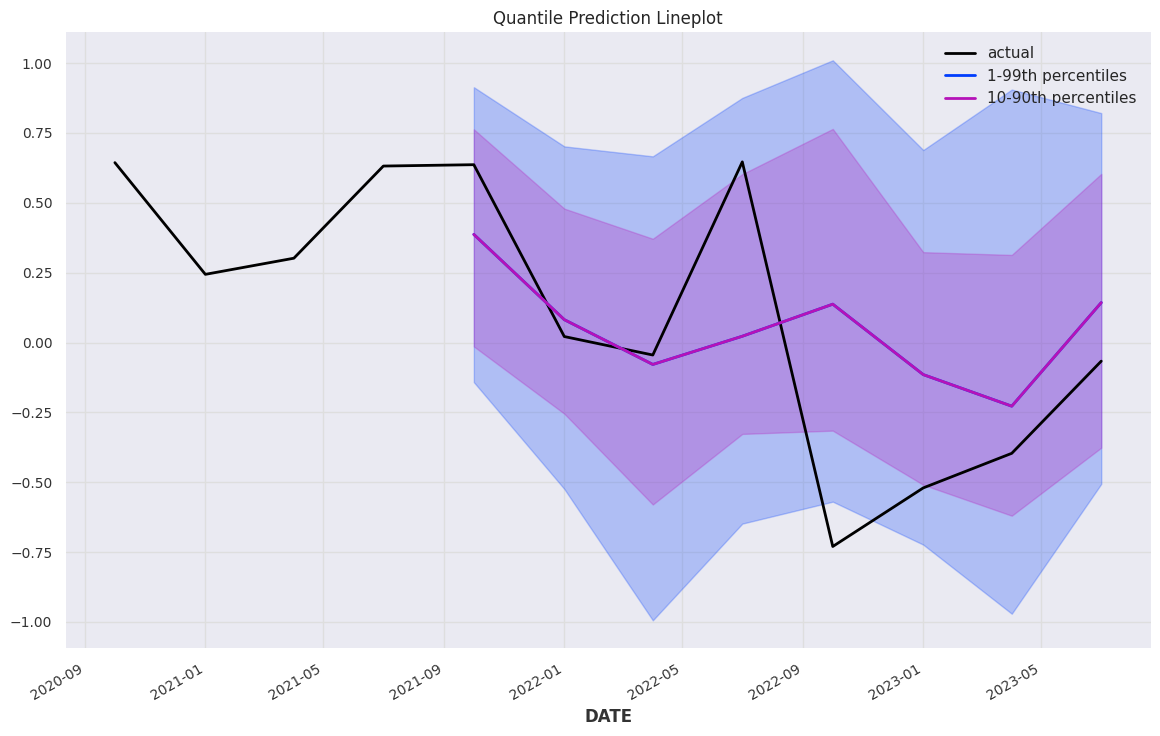

In [ ]:
# Calculate the start time for the plot
plot_start_time = forecast.start_time() - (forecast.freq * (4))

# Slicing the actual series to the relevant range
series_transformed_sliced = st.slice(plot_start_time, forecast.end_time())

# plot actual series
plt.figure(figsize=figsize)
series_transformed_sliced.plot(label="actual")

# plot prediction with quantile ranges
forecast.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
forecast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title("Quantile Prediction Lineplot")
plt.legend()
plt.show()

In [ ]:
"""
sns.color_palette("bright")
plot_start_time = forecast.start_time() - (forecast.freq * (0))

# Slicing the actual series to the relevant range
series_transformed_sliced = st.slice(plot_start_time, forecast.end_time())

# plot actual series
plt.figure(figsize=(12, 4))  # Adjusting the figure size to match the second script
series_transformed_sliced.plot(label="Actual Values", marker='o', color='blue')  # Adding marker and color

# plot prediction with quantile ranges
# Assigning different colors for the forecast plots
#forecast.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer, marker='x', color='blue')
forecast.plot(low_quantile=low_q,high_quantile=high_q,label=label_q_inner,  marker='x', color='chocolate')#

plt.title("TFT EUNG Quantile Prediction Lineplot")
plt.xlabel('Time')  # Adding xlabel to match the second script
plt.ylabel('Value')  # Adding ylabel, replace 'Value' with the appropriate measurement if needed
plt.legend()
plt.show()
"""

In [ ]:
print(f"MAE: {mae(eval, forecast):.4f}")
print(f"MAPE: {mape(eval, forecast):.4f} %")
print(f"MSE: {mse(eval, forecast):.4f}")
print(f"RMSE: {rmse(eval, forecast):.4f}")

MAE: 0.3273
MAPE: 130.9709 %
MSE: 0.1807
RMSE: 0.4251


## Save Predictions

In [ ]:
main_prediction = forecast.quantile_timeseries(quantile=0.5)
df = main_prediction.pd_dataframe()
df=df.rename(columns={'EUNG_0.5': 'EUNG Q TFT'})
df.to_excel("EUNG_Q_TFT_forecast.xlsx", index=True)
df

component,EUNG Q TFT
DATE,
2021-10-01,0.386795
2022-01-01,0.081782
2022-04-01,-0.078533
2022-07-01,0.022412
2022-10-01,0.137150
2023-01-01,-0.114867
2023-04-01,-0.227856
2023-07-01,0.142791


In [ ]:
# Open a file in write mode
with open('EUNG Q TFT Results.txt', 'w') as file:
    # Write the variables to the file
    file.write(f'{mae(eval, forecast):.4f}\n')
    file.write(f'{mape(eval, forecast):.4f}\n')
    file.write(f'{mse(eval, forecast):.4f}\n')
    file.write(f'{rmse(eval, forecast):.4f}\n')